In [1]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 71.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 59.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.2/591.2 kB 23.9 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1275 sha256=417c77dff4ced0fc99f83be3c7b9e681b1cd2f13be54e09ffb537746395f4319
  Stored in directory: /home/codespace/.cache/pip/wheels/62/0e/84/39e1c8bf2f2da63964fe43fb2932027d6344f8766edf28bc8c
Successfully built mecab-python

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Install mecab-ko
  % Total    % Received % Xferd  Average Speed 

In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")


('ratings_test.txt', <http.client.HTTPMessage at 0x72a781985430>)

In [5]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
print('훈련용 리뷰 개수 :', len(train_data))
print('테스트용 리뷰 개수 :', len(train_data))

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 150000


<Axes: xlabel='label'>

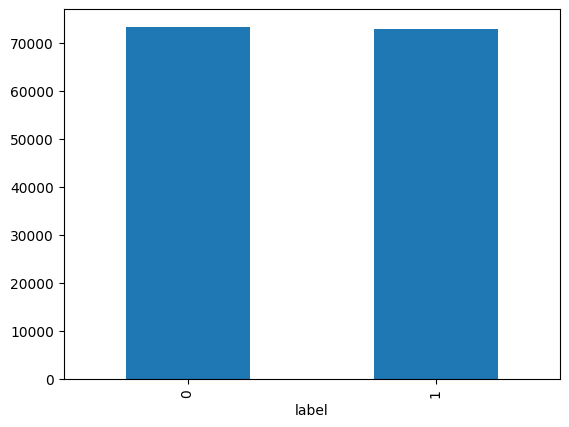

In [7]:
train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복 제거
train_data['label'].value_counts().plot(kind='bar')

In [10]:
print(train_data['label'].value_counts())  # 레이블 종류

label
0    73342
1    72841
Name: count, dtype: int64


In [17]:
print(train_data['document'].isnull().sum())  # 결측치 개수
train_data= train_data.dropna()  # 결측치 제거
print(train_data['document'].isnull().sum())  # 결측치 개수

1
0


In [18]:
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎ-ㅏ-ㅣ가-힣 ]', '', regex=True)  # 정규 표현식
train_data[:5]

/tmp/ipykernel_3319/1507379552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎ-ㅏ-ㅣ가-힣 ]', '', regex=True)  # 정규 표현식


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [19]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True)
# white space 데 이 터 를 empty value로 변 경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    762
label         0
dtype: int64


/tmp/ipykernel_3319/2189795593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True)
/tmp/ipykernel_3319/2189795593.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['document'].replace('', np.n

In [22]:
train_data.loc[train_data.document.isnull()][:5]
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145420


In [24]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열 에 서 중 복 인 내 용 이 있 다 면 중 복 제 거
test_data['document'] = test_data['document'].str.replace("[^ㄱ -ㅎ ㅏ -ㅣ 가 -힣 ]","" , regex=True) # 정 규 표 현 식 수 행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공 백 은 empty 값 으 로 변 경
test_data['document'].replace('', np.nan, inplace=True) # 공 백 은 Null 값 으 로 변 경
test_data = test_data.dropna(how='any') # Null 값 제 거 print('전 처 리 후 테 스 트 용 샘 플 의 개 수 :',len(test_data))

/tmp/ipykernel_3319/623287325.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['document'].replace('', np.nan, inplace=True) # 공 백 은 Null 값 으 로 변 경


In [26]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

mecab = Mecab()
mecab.morphs('와 이런것도 영화라고 차라리 뮤비를 만드는게 나을듯')

['와',
 '이런',
 '것',
 '도',
 '영화',
 '라고',
 '차라리',
 '뮤',
 '비',
 '를',
 '만드',
 '는',
 '게',
 '나을',
 '듯']

In [35]:
X_train = []
for sent in tqdm(train_data['document']):
    tokenized_sentence = mecab.morphs(sent)
    tokenized_sentence = [i for i in tokenized_sentence if i not in stopwords]
    X_train.append(tokenized_sentence)

100%|██████████| 145420/145420 [00:08<00:00, 16893.10it/s]


In [36]:
print(X_train[:5])

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다'], ['교도소', '이야기', '구먼', '솔직히', '재미', '없', '평점', '조정'], ['사이몬페그', '익살', '스런', '연기', '돋보였', '던', '영화', '스파이더맨', '에서', '늙', '어', '보이', '기', '만', '했', '던', '커스틴', '던스트', '너무나', '이뻐', '보였']]


In [37]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train, train_data['label'], test_size=0.2, random_state=0, stratify=y_train)

In [38]:
print('--------학 습 데 이 터 의 비 율 -----------')
print(f'부 정 리 뷰 = {round(np.sum(y_train==0)/len(y_train) * 100,3)}%')
print(f'긍 정 리 뷰 = {round(np.count_nonzero(y_train)/len(y_train) * 100,3)}%')
print('--------검 증 데 이 터 의 비 율 -----------')
print(f'부 정 리 뷰 = {round(np.sum(y_valid==0)/len(y_valid) * 100,3)}%')
print(f'긍 정 리 뷰 = {round(np.count_nonzero(y_valid)/len(y_valid) * 100,3)}%')
print('--------테 스 트 데 이 터 의 비 율 -----------')
print(f'부 정 리 뷰 = {round(np.sum(y_test==0)/len(y_test) * 100,3)}%')
print(f'긍 정 리 뷰 = {round(np.count_nonzero(y_test)/len(y_test) * 100,3)}%')

--------학 습 데 이 터 의 비 율 -----------
부 정 리 뷰 = 50.237%
긍 정 리 뷰 = 49.763%
--------검 증 데 이 터 의 비 율 -----------
부 정 리 뷰 = 50.237%
긍 정 리 뷰 = 49.763%
--------테 스 트 데 이 터 의 비 율 -----------
부 정 리 뷰 = 49.73%
긍 정 리 뷰 = 50.27%


In [47]:
word_list = []
for sentence in tqdm(X_train):
    for word in sentence:
        word_list.append(word)
word_count = Counter(word_list)
word_count[:10]

 16%|█▌        | 18207/116336 [00:00<00:00, 181256.44it/s]

100%|██████████| 116336/116336 [00:00<00:00, 200390.37it/s]


0

In [48]:
word_list

['연기력',
 '최악',
 '예술가',
 '삶',
 '아름다움',
 '찾',
 '갈망',
 '보이',
 '영화',
 '항상',
 '진지',
 '함',
 '없이',
 '세상',
 '무',
 '관심',
 '휴',
 '그랜트',
 '식',
 '언어',
 '연기',
 '로',
 '소소',
 '미소',
 '짓',
 '것',
 '관람',
 '포인트',
 '정작',
 '자신',
 '삶',
 '진지',
 '함',
 '조금',
 '씩',
 '깨달',
 '으려는',
 '노력',
 '영화',
 '매력',
 '우리나라',
 '수준',
 '미달',
 '평론가',
 '만',
 '있',
 '나',
 '재밌',
 '어요',
 '꼭',
 '보',
 '세요',
 '기대치',
 '너무',
 '높여',
 '놔서',
 '그런지',
 '핵',
 '노',
 '잼',
 '노',
 '답',
 '답답',
 '민폐',
 '캐릭터',
 '너무',
 '많',
 '뭔',
 '소설',
 '인가',
 '대사',
 '너무',
 '심하',
 '길',
 '많',
 '자본주의',
 '추악',
 '뒷모습',
 '인간',
 '욕망',
 '대한',
 '냉소',
 '적',
 '시선',
 '보내',
 'ㅎㅎㅎ',
 '지루함',
 '없이',
 '전개',
 '되',
 '스토리',
 '덕분',
 '시간',
 '줄',
 '모르',
 '푹',
 '빠져서',
 '보',
 '왔',
 '이게',
 '점대',
 '라고',
 '말',
 '안',
 '돼',
 '안',
 '돼도',
 '점대',
 '줘야지',
 '소재',
 '독특',
 '한데',
 '허접',
 '함',
 '보',
 '면서',
 '잘',
 '잤',
 '음',
 '그동안',
 '잠',
 '못',
 '잤',
 '는데',
 '학교',
 '시간',
 '이거',
 '보',
 '니까',
 '잠',
 '존나',
 '잘',
 '오',
 '더라',
 '아직',
 '잊',
 '수',
 '없',
 '드라마',
 'ㅜㅜ',
 '맨',
 '오브',
 '스틸',
 '봤',
 '기대',
 '한참',
 '모자른',


In [49]:
X_test = []
for sent in tqdm(test_data['document']):
    tokenized_sentence = mecab.morphs(sent)
    tokenized_sentence = [i for i in tokenized_sentence if i not in stopwords]
    X_test.append(tokenized_sentence)

  1%|          | 277/49157 [00:00<00:17, 2750.45it/s]

100%|██████████| 49157/49157 [00:04<00:00, 9987.59it/s] 


In [59]:
print(sum(word_count.values()))
26105/sum(word_count.values())

1433333


0.018212794933208123

In [55]:
threshold = 3
rare_cnt = 0
rare_freq = 0
total_freq = 0
total_cnt = len(word_list)
for word in word_list:
    total_freq += word_count[word]
    if word_count[word] < threshold:
        rare_cnt += 1
        rare_freq += word_count[word]
print('등 장 빈 도 가 %s번 이 하 인 희 귀 단 어 의 수: %s'%(threshold - 1, rare_cnt))
print("단 어 집 합 에 서 희 귀 단 어 의 비 율:", (rare_cnt / total_cnt)*100)
print("전 체 등 장 빈 도 에 서 희 귀 단 어 등 장 빈 도 비 율:", (rare_freq / total_freq) *100)

등 장 빈 도 가 2번 이 하 인 희 귀 단 어 의 수: 32540
단 어 집 합 에 서 희 귀 단 어 의 비 율: 2.270233086100718
전 체 등 장 빈 도 에 서 희 귀 단 어 등 장 빈 도 비 율: 0.0007545664478757165


In [60]:
word_list = []
for sent in X_train:
    for word in sent:
        word_list.append(word)

word_counts = Counter(word_list)
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등 장 빈 도 수 상 위 10개 단 어')
print(vocab[:10])

threshold = 3
total_cnt = len(word_counts) # 단 어 의 수
rare_cnt = 0 # 등 장 빈 도 수 가 threshold보 다 작 은 단 어 의 개 수 를 카 운 트
total_freq = 0 # 훈 련 데 이 터 의 전 체 단 어 빈 도 수 총 합
rare_freq = 0 # 등 장 빈 도 수 가 threshold보 다 작 은 단 어 의 등 장 빈 도 수 의 총 합
# 단 어 와 빈 도 수 의 쌍(pair)을 key와 value로 받 는 다.
for key, value in word_counts.items():
    total_freq = total_freq + value
    # 단 어 의 등 장 빈 도 수 가 threshold보 다 작 으 면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
print('단 어 집 합(vocabulary)의 크 기 :',total_cnt)
print('등 장 빈 도 가 %s번 이 하 인 희 귀 단 어 의 수: %s'%(threshold - 1, rare_cnt))
print("단 어 집 합 에 서 희 귀 단 어 의 비 율:", (rare_cnt / total_cnt)*100)
print("전 체 등 장 빈 도 에 서 희 귀 단 어 등 장 빈 도 비 율:", (rare_freq / total_freq) *100)

등 장 빈 도 수 상 위 10개 단 어
['영화', '보', '있', '없', '좋', '나', '었', '만', '는데', '너무']
단 어 집 합(vocabulary)의 크 기 : 45374
등 장 빈 도 가 2번 이 하 인 희 귀 단 어 의 수: 26160
단 어 집 합 에 서 희 귀 단 어 의 비 율: 57.65416317714991
전 체 등 장 빈 도 에 서 희 귀 단 어 등 장 빈 도 비 율: 2.270233086100718


In [62]:
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1
for i, w in enumerate(vocab):
    word_to_index[w] = i + 2

In [69]:
max_len = max([i for i in map(len, X_train)])
def token_to_index(words, word_to_index, max_len):
    result = []
    for word in words:
        index = word_to_index.get(word, word_to_index['<UNK>'])
        result.append(index)
    result += [0] * (max_len - len(result))
    return result

X_train = list(map(lambda x: token_to_index(x, word_to_index, max_len), X_train))
print(X_train[:10])

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 